<a href="https://colab.research.google.com/github/junyong1111/KMU-2022/blob/main/Keras_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import math
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [3]:
import os
if not os.path.exists('darknet'):
    os.makedirs('darknet')
%cd darknet
%ls
!ls -la '/content/drive/MyDrive/Kobot/YOLO/darknet/bin/darknet'
!cp -r /content/drive/MyDrive/Kobot/YOLO/darknet/bin/darknet ./darknet
!chmod +x ./darknet
#YOLO data 가져오기
#!cp -r /content/drive/MyDrive/Kobot/YOLO/darknet/weights .
#!cp -r /content/drive/MyDrive/Kobot/YOLO/darknet/cfg .
#!cp -ar /content/drive/MyDrive/Kobot/YOLO/darknet/data .

# Custom data가 있는 폴더 복사
#!cp -r /content/drive/MyDrive/Kobot/YOLO/darknet/backup .
#!cp -r /content/drive/MyDrive/Capstone/recipe_data/ .
!cp -r /content/drive/MyDrive/Capstone/재료/ .
!cp -r /content/drive/MyDrive/Capstone/재료.W/ .
%ls

/content/darknet
-rw------- 1 root root 6845664 Feb 15 15:12 /content/drive/MyDrive/Kobot/YOLO/darknet/bin/darknet
재료/  darknet*  재료.W/


In [11]:
batch_size = 128
num_classes = 0
epochs = 100
CW = 32
CH = 32
CD = 3
model_name = 'capstone_custom.h5'
#tflite_model_name = 'fruit_custom.tflite'
COLAB_PATH = '/content/drive/MyDrive/Capstone'
YOLO_IMAGE_PATH =COLAB_PATH + '/재료/'
YOLO_FORMAT_PATH =COLAB_PATH+  '/재료/'
classes = []

train_imgs= []
train_labels = []
test_imgs = []
test_labels = []

sample_test_img = 'sample.test.jpg'
sample_test_label = 0

In [13]:
def show_sample(img, labels, sample_count = 25):
    grid_cnt = math.ceil(math.ceil(math.sqrt(sample_count)))
    grid_cnt = min(grid_cnt, len(img,), len(labels))

    plt.figure(figsize=(2*grid_cnt, 2*grid_cnt))
    for i in range(sample_count):
        plt.subplot(grid_cnt, grid_cnt, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.xlabel(labels[i])
    plt.show()

def download(path):
    try:
        from google.colab import files
        files.download(path)
    except ImportError:
        import os
        print("Eorror Download:", os.path.join(os.getcwd(),path))


def getROI(size, box):
    width_ratio = size[1]
    height_ratio = size[0]
    x = float(box[1]) * width_ratio
    y = float(box[2]) * height_ratio
    w = float(box[3]) * width_ratio   
    h = float(box[4]) * height_ratio

    half_width = w/2.0
    half_height = h/2.0
    startX = int(x-half_width)
    startY = int(y-half_height)
    endX = int(x+half_width)
    endY = int(y+half_height)
    return (startY, endY, startX, endX)

def imShow(path):
    fig = plt.gcf()
    plt.axis("off")
    plt.imshow(cv2.cvtColor(path, cv2.COLOR_BGR2RGB))
    plt.show()

In [14]:
%cd /content/darknet

/content/darknet


## test, train을 다시 분류

In [15]:
current_path = os.path.abspath(os.curdir)
print(current_path)
class_count = 0 # 클래스 개수
test_percentage  = 0.2 #test 비율
paths = []
##### 로컬 데이터를 변경하기 위해 수정 다시 돌리려면 위 cd명령어를 돌려야함
KERAS_PATH = '/content/darknet/재료'

os.chdir(KERAS_PATH)
for current_dir, dirs, files in os.walk('.'):
    for f in files:
        if (f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png') ):
            image_path = current_path + '/재료/' + f
            #print(image_path)
            paths.append(image_path + '\n')

paths_test = paths[:int(len(paths) * test_percentage)]
paths = paths[int(len(paths) * test_percentage) :]


with open(KERAS_PATH + '/' + 'train.txt', 'w') as train_txt:
    for path in paths :
        train_txt.write(path)
    print("[train_txt] is created")

with open(KERAS_PATH + '/' + 'test.txt', 'w') as test_txt:
    for path in paths_test :
        test_txt.write(path)
    print("[test_txt] is created")  

/content/darknet
[train_txt] is created
[test_txt] is created


In [16]:
with open(KERAS_PATH + '/' + 'classes.txt' , 'r') as txt:
    for line in txt:
        name = line.replace("\n", "")
        classes.append(name)
        num_classes +=1
    print(classes, num_classes)

['고구마', '고등어', '다진마늘', '당근', '미나리', '밤', '방울토마토', '배', '배추', '생강', '식빵', '양파', '오이', '청양고추', '햄'] 15


In [17]:
image_cnt = 0
  
    
with open(KERAS_PATH +'/' + 'train.txt' , 'r') as txt:
    for line in txt:
        
        image_path = line.replace("\n","")
        print(image_path)
        img = cv2.imread(image_path)
        size = img.shape[:2]
        if (image_path.endswith('.jpg')  or image_path.endswith('.png') ):
          text_path = image_path[:-4] + '.txt'
        elif(image_path.endswith('.jpeg')):
          text_path = image_path[:-5] + '.txt'

        with open(text_path, 'r') as txt:
            for line in txt:
                box = line.split()
                (startY, endY, startX, endX) = getROI(size, box)
                image = cv2.resize(img[startY:endY, startX:endX], (CW,CH), interpolation = cv2.INTER_AREA)
                train_imgs.append(image)
                train_labels.append(int(box[0]))
                image_cnt +=1

train_images = np.array(train_imgs)
train_labels = np.array(train_labels)

train_images =  train_images.astype("float32") /255.0
train_labels = keras.utils.to_categorical(train_labels, num_classes)
print('%d images added' % image_cnt)

/content/darknet/재료/햄9.jpg
/content/darknet/재료/고등어12.jpg
/content/darknet/재료/밤27.jpg
/content/darknet/재료/오이10.jpg
/content/darknet/재료/오이28.jpg
/content/darknet/재료/당근16.jpg
/content/darknet/재료/고등어42.jpg
/content/darknet/재료/배11.jpg
/content/darknet/재료/햄15.jpg
/content/darknet/재료/미나리1.jpg
/content/darknet/재료/청양고추33.jpg
/content/darknet/재료/당근19.jpg
/content/darknet/재료/다진마늘20.jpg
/content/darknet/재료/양파27.jpg
/content/darknet/재료/양파18.jpg
/content/darknet/재료/당근29.jpg
/content/darknet/재료/밤18.jpg
/content/darknet/재료/고등어30.jpg
/content/darknet/재료/미나리21.jpg
/content/darknet/재료/다진마늘15.jpg
/content/darknet/재료/고등어13.jpg
/content/darknet/재료/생강42.jpg
/content/darknet/재료/방울토마토49.jpg
/content/darknet/재료/고구마15_1.jpg
/content/darknet/재료/배24.jpg
/content/darknet/재료/고등어9.jpg
/content/darknet/재료/생강5.jpg
/content/darknet/재료/배추5.jpg
/content/darknet/재료/고등어31.jpg
/content/darknet/재료/오이7.jpg
/content/darknet/재료/

In [18]:
image_cnt = 0
  
    
with open(KERAS_PATH +'/' + 'test.txt' , 'r') as txt:
    for line in txt:
        
        image_path = line.replace("\n","")
        print(image_path)
        img = cv2.imread(image_path)
        size = img.shape[:2]
        if (image_path.endswith('.jpg')  or image_path.endswith('.png') ):
          text_path = image_path[:-4] + '.txt'
        elif(image_path.endswith('.jpeg')):
          text_path = image_path[:-5] + '.txt'

        with open(text_path, 'r') as txt:
            for line in txt:
                box = line.split()
                (startY, endY, startX, endX) = getROI(size, box)
                image = cv2.resize(img[startY:endY, startX:endX], (CW,CH), interpolation = cv2.INTER_AREA)
                test_imgs.append(image)
                test_labels.append(int(box[0]))
                image_cnt +=1

test_images = np.array(test_imgs)
test_labels = np.array(test_labels)

test_images =  test_images.astype("float32") /255.0
test_labels = keras.utils.to_categorical(test_labels, num_classes)
print('%d images added' % image_cnt)

/content/darknet/재료/다진마늘11.jpg
/content/darknet/재료/햄6.jpg
/content/darknet/재료/방울토마토31.jpg
/content/darknet/재료/햄48.jpg
/content/darknet/재료/방울토마토50.jpg
/content/darknet/재료/방울토마토12.jpg
/content/darknet/재료/방울토마토47.jpg
/content/darknet/재료/오이33.jpg
/content/darknet/재료/배추27.jpg
/content/darknet/재료/식빵49.jpg
/content/darknet/재료/고등어8.jpg
/content/darknet/재료/식빵4.jpg
/content/darknet/재료/당근8.jpg
/content/darknet/재료/배28.jpg
/content/darknet/재료/청양고추28.jpg
/content/darknet/재료/방울토마토22.jpg
/content/darknet/재료/고구마37.jpg
/content/darknet/재료/고구마30.jpg
/content/darknet/재료/배10.jpg
/content/darknet/재료/배추22.jpg
/content/darknet/재료/양파16.jpg
/content/darknet/재료/식빵12.jpg
/content/darknet/재료/밤33.jpg
/content/darknet/재료/방울토마토3.jpg
/content/darknet/재료/양파11.jpg
/content/darknet/재료/고구마34.jpg
/content/darknet/재료/미나리30.jpg
/content/darknet/재료/밤38.jpg
/content/darknet/재료/다진마늘2.jpg
/content/darknet/재료/청양고

Tatal number of Images : 833


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54660 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48164 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_

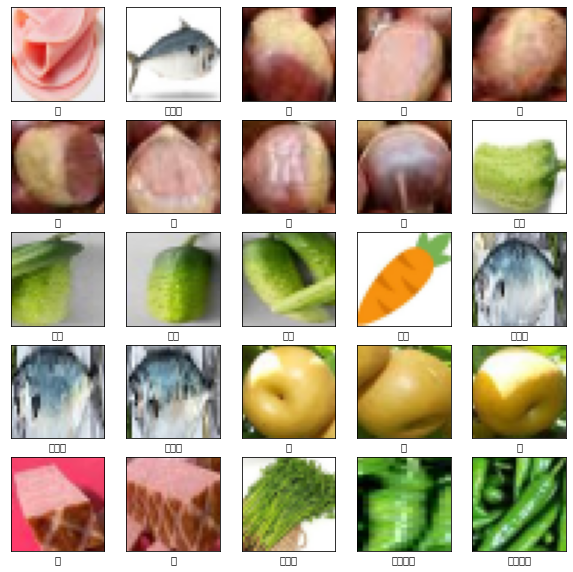

In [19]:
show_number = len(train_images)
print("Tatal number of Images : %d"  % show_number)

if(show_number >25):
    show_number = 25
show_sample(train_images, 
            [ '%s' % classes[np.argmax(label)] for label in train_labels], show_number)

Tatal number of Images : 83


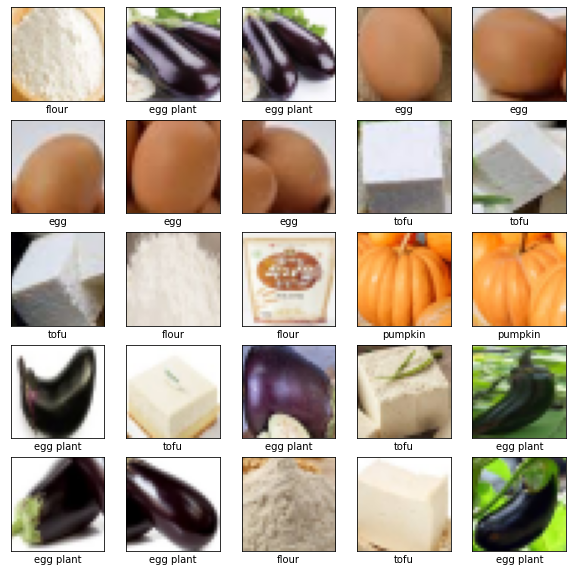

In [ ]:
show_number = len(test_images)
print("Tatal number of Images : %d"  % show_number)

if(show_number >25):
    show_number = 25
show_sample(test_images, 
            [ '%s' % classes[np.argmax(label)] for label in test_labels], show_number)

In [20]:
inputShape = (CH, CW, CD)

model = keras.Sequential([
                          keras.layers.Flatten(input_shape = inputShape),

                          keras.layers.Reshape(target_shape = inputShape),
                          keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation = tf.nn.relu),
                          keras.layers.Conv2D(filters=64, kernel_size =(3,3), activation=tf.nn.relu),
                          keras.layers.MaxPooling2D(pool_size =(2,2,)),
                          keras.layers.Dropout(0.25),
                          keras.layers.Flatten(input_shape=(28,28)),
                          keras.layers.Dense(128, activation = tf.nn.relu),
                          keras.layers.Dropout(0.5),

                          keras.layers.Dense(num_classes, activation= tf.nn.softmax)
])

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


### fashion data

In [21]:
# Save the best model as digits_model.h5
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only = True)

# Define a callback to monitor val_loss
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                 patience =5)

In [25]:
# Train the model usisng the early stopping callback
epochs = 100
history = model.fit(train_images, train_labels,
                    validation_data= (test_images, test_labels),
                    epochs = epochs, batch_size = batch_size,
                    #callbacks =[earlyStopping, modelCheckpoint])
                    callbacks =[modelCheckpoint])

Epoch 1/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0489 - accuracy: 0.9820 - val_loss: 1.9215 - val_accuracy: 0.7406
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0404 - accuracy: 0.9856 - val_loss: 2.1397 - val_accuracy: 0.7170
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0364 - accuracy: 0.9892 - val_loss: 1.8337 - val_accuracy: 0.7406
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0306 - accuracy: 0.9904 - val_loss: 1.7692 - val_accuracy: 0.7170
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0241 - accuracy: 0.9928 - val_loss: 1.7919 - val_accuracy: 0.7217
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0174 - accuracy: 0.9964 - val_loss: 1.8552 - val_accuracy: 0.7406
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0275 - accuracy: 0.9916 - val_loss: 1.7908 - val_accuracy: 0.7358
Epoch 8/100
7/7 [===

In [23]:
download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7/7 [==============================] - 0s 5ms/step - loss: 2.2467 - accuracy: 0.7264
Test Accuracy: 0.7264150977134705


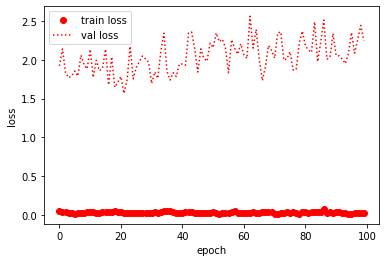

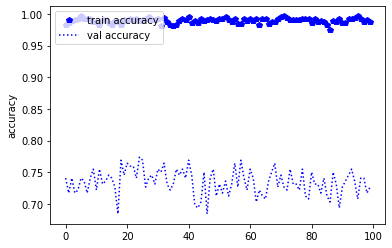

In [26]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print("Test Accuracy:", test_acc)

fig, loss_ax = plt.subplots()
gix, acc_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'ro', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r:', label= 'val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'bp', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'b:', label= 'val accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45720 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54660 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48164 missing from current font.
  font.set_

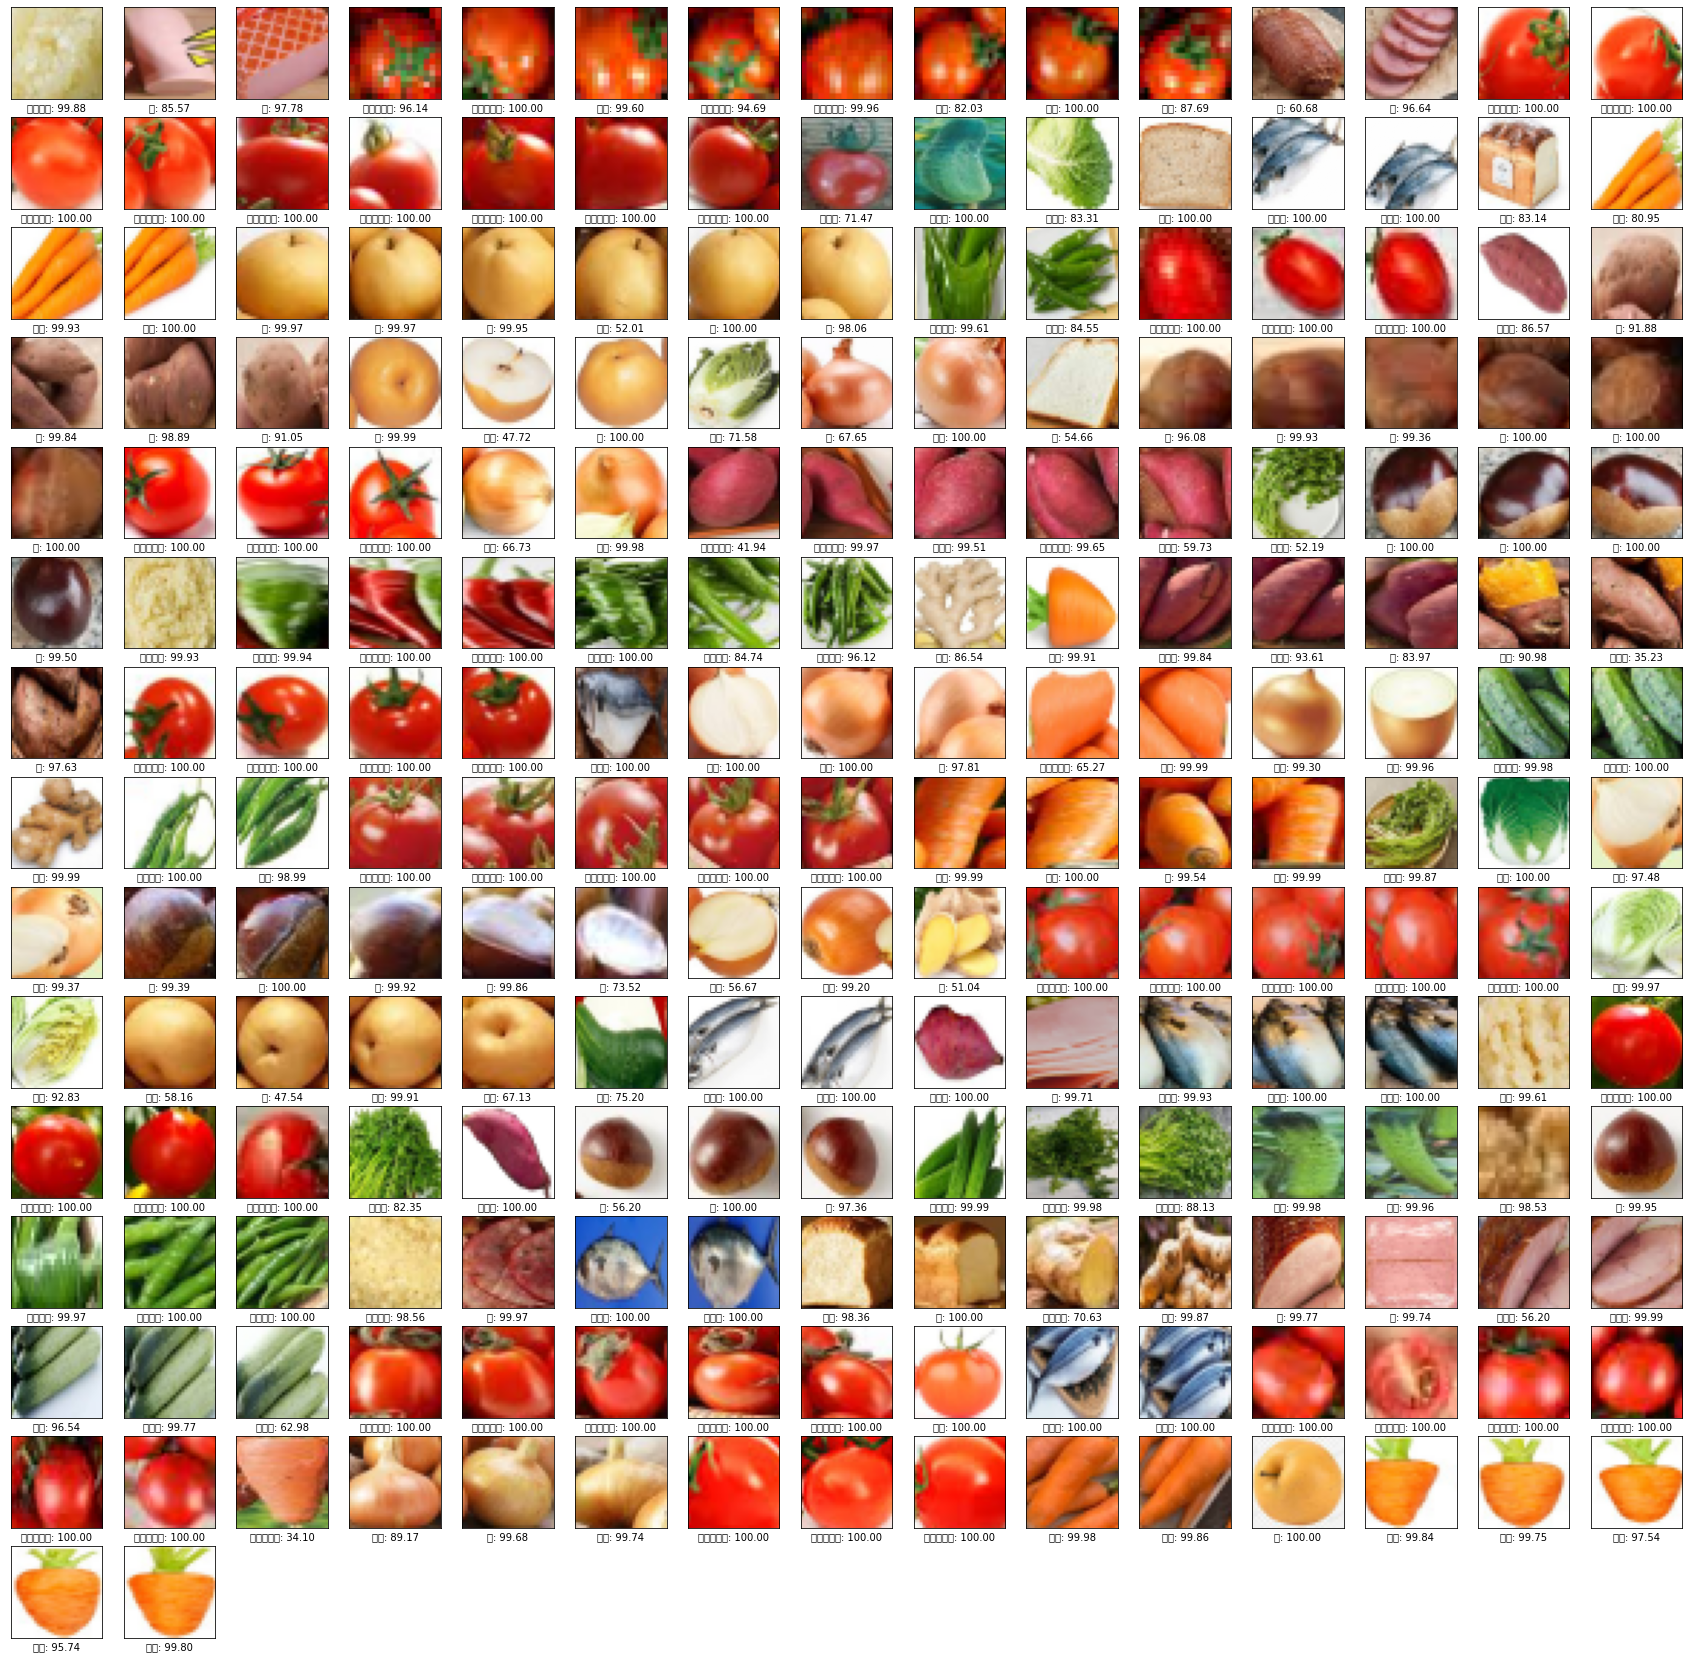

In [27]:
predictions = model.predict(test_images)

show_sample(test_images,
            ['%s: %.2f' % (classes[np.argmax(result)], result[np.argmax(result)]*100) for result in predictions], 
            len(predictions))

방울토마토 : 100.00


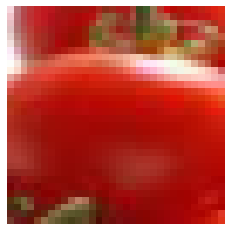

In [57]:
import random
seleted_digit = random.randint(0,25) 

result = predictions[seleted_digit]
result_number = np.argmax(result)
print('%s : %.2f' % (classes[result_number], result[result_number] * 100))

imShow(test_images[seleted_digit])